## 개요
- NLP(Natural Language Processing)
- google의 BERT 모델 활용
- IMDB 영화 리뷰 dataset을 학습데이터로 사용
- 각 리뷰를 별점을 기준으로 positive, negative로 분류 
- 특정 영화에 대한 리뷰를 분석하여 해당 영화에 대한 관람객의 평가를 도출 
<br>(긍정: x %, 부정: y%)
- 새로운 리뷰가 작성되었을 때 종합 평가에 즉각적으로 반영

## 활용
- 별점이 없는 리뷰에 대해서도 예상 별점을 책정할 수 있음 
- 별점과 리뷰가 서로 상이한 리뷰에 대해서 필터링을 통해 비교적 더 정확한 평가를 제공할 수 있음
- 영화에 대한 리뷰를 통해 개별 추천 시스템을 고도화 할 수 있음   

In [ ]:
!pip install -q tf-models-official

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 79.2 MB/s eta 0:00:00


In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # AdamW opimizer를 생성하기 위해

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# 현재 프로젝트에 적용중인 모델과 동일한 데이터 셋
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# 불필요한 폴더 제거거
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

84125825/84125825 [==============================] - 6s 0us/step


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [ ]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

In [ ]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [ ]:
# bert 전처리 레이어
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
# 전처리 레이어 통과후 text 벡터화 결과
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

# 'input_word_ids': 텍스트 데이터를 정수 시퀀스로 변환한 결과
# 'input_mask': 입력 토큰 시퀀스의 패딩 여부(0과 1)를 나타내는 mask 정보
# 'input_type_ids':  입력 시퀀스의 문장 구분(?)
print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}') 
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')  

Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

# Pooled Output : 입력 시퀀스의 모든 토큰의 정보를 요약하여 하나의 벡터로 만든 것, 입력 시퀀스에 대한 문맥적 의미
# Sequence Output : 입력 시퀀스의 모든 토큰에 대한 정보를 담고 있는 출력, 각 토큰의 출력값을 연결하여 만든 시퀀스 형태의 벡터
print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.7626294   0.9928099  -0.18611868  0.3667384   0.15233697  0.6550447
  0.9681154  -0.94862723  0.00216173 -0.9877732   0.06842681 -0.97630596]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.2894635   0.34321314  0.33231482 ...  0.21300751  0.7102076
  -0.0577114 ]
 [-0.2874215   0.31981048 -0.23018587 ...  0.5845506  -0.21329802
   0.72692144]
 [-0.6615703   0.68876755 -0.87433    ...  0.10877246 -0.26173204
   0.47855428]
 ...
 [-0.22561137 -0.2892561  -0.07064435 ...  0.47566015  0.8327713
   0.4002532 ]
 [-0.29824218 -0.27473158 -0.05450481 ...  0.4884971   1.0955353
   0.18163383]
 [-0.4437822   0.00930763  0.07223707 ...  0.1729007   1.1833245
   0.07898022]]


In [ ]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result)) # 모델에서 반환되는 출력은 raw data이므로 sigmoid fn을 통과 시켜 확률값 출력력

NameError: ignored

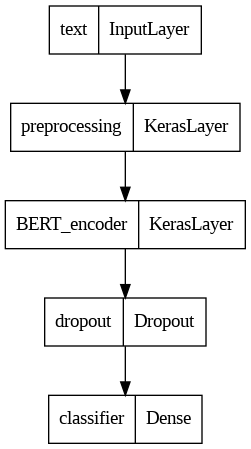

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True) # 이진 분류 이기 때문에 BinaryCrossentropy 손실함수 적용, 모델의 마지막 출력층이 확률 분포를 내보내지 않기 때문에 from_logis=True
metrics = tf.metrics.BinaryAccuracy() # 이진 분류 : BinarayAccuracy 적용

In [ ]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy() # epoch당 반복할 스텝 수
num_train_steps = steps_per_epoch * epochs                           # 전체 학습을 마치는데 필요한 스텝 수를 결정
num_warmup_steps = int(0.1*num_train_steps)                          # warmup은 초기 스텝에서 learning rate를 점진적으로 증가시키는 과정

init_lr = 3e-5 # learning_rate = 0.00003
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw') # Adamw: L2 regularization을 Adam Optimizer에 결합, 가중치 감쇠를 적용

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
625/625 [==============================] - 4371s 7s/step - loss: 0.4801 - binary_accuracy: 0.7516 - val_loss: 0.3951 - val_binary_accuracy: 0.8344
Epoch 2/5
625/625 [==============================] - 4294s 7s/step - loss: 0.3259 - binary_accuracy: 0.8549 - val_loss: 0.3778 - val_binary_accuracy: 0.8432
Epoch 3/5
625/625 [==============================] - 4336s 7s/step - loss: 0.2476 - binary_accuracy: 0.8962 - val_loss: 0.3798 - val_binary_accuracy: 0.8504
Epoch 4/5
625/625 [==============================] - 4264s 7s/step - loss: 0.1883 - binary_accuracy: 0.9262 - val_loss: 0.4419 - val_binary_accuracy: 0.8512
Epoch 5/5
625/625 [==============================] - 4292s 7s/step - loss: 0.1472 - binary_accuracy: 0.9428 - val_loss: 0.4707 - val_binary_accuracy: 0.8506


In [ ]:
classifier_model.save('./drive/MyDrive/example2_model')

In [ ]:
from google.colab import files

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')